# AutoMPG
The task is to predict the MPG for different cars based on a selected set of properties about the cars. It is a regression task, but the main challenge is data preparation.

In [1]:
# Common imports
import sklearn
import numpy as np
import pandas as pd

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
# Load the dataset
filepath = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
data = pd.read_fwf(filepath, header=None);
data.head()

,0,1,2,3,4,5,6,7,8
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


In [3]:
# Remove the last column which is non-numerical
data = data.drop(8, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       398 non-null    float64
 1   1       398 non-null    int64  
 2   2       398 non-null    float64
 3   3       398 non-null    object 
 4   4       398 non-null    float64
 5   5       398 non-null    float64
 6   6       398 non-null    int64  
 7   7       398 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


In [4]:
# Rename columns
data = data.rename(columns={0: 'mpg', 1: 'cylinders', 2: 'displacement', 3: 'hp', 4: 'weight', 5: 'acc', 6: 'year', 7: 'origin'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   hp            398 non-null    object 
 4   weight        398 non-null    float64
 5   acc           398 non-null    float64
 6   year          398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


In [5]:
# Remove rows where horsepower is ?
#data = data[data.hp != '?']

# Alternative:
data['hp'] = data['hp'].replace('?', np.nan)
data = data.dropna()

# Convert the datatype from "object" to "float"
data['hp'] = data['hp'].astype(float)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   hp            392 non-null    float64
 4   weight        392 non-null    float64
 5   acc           392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


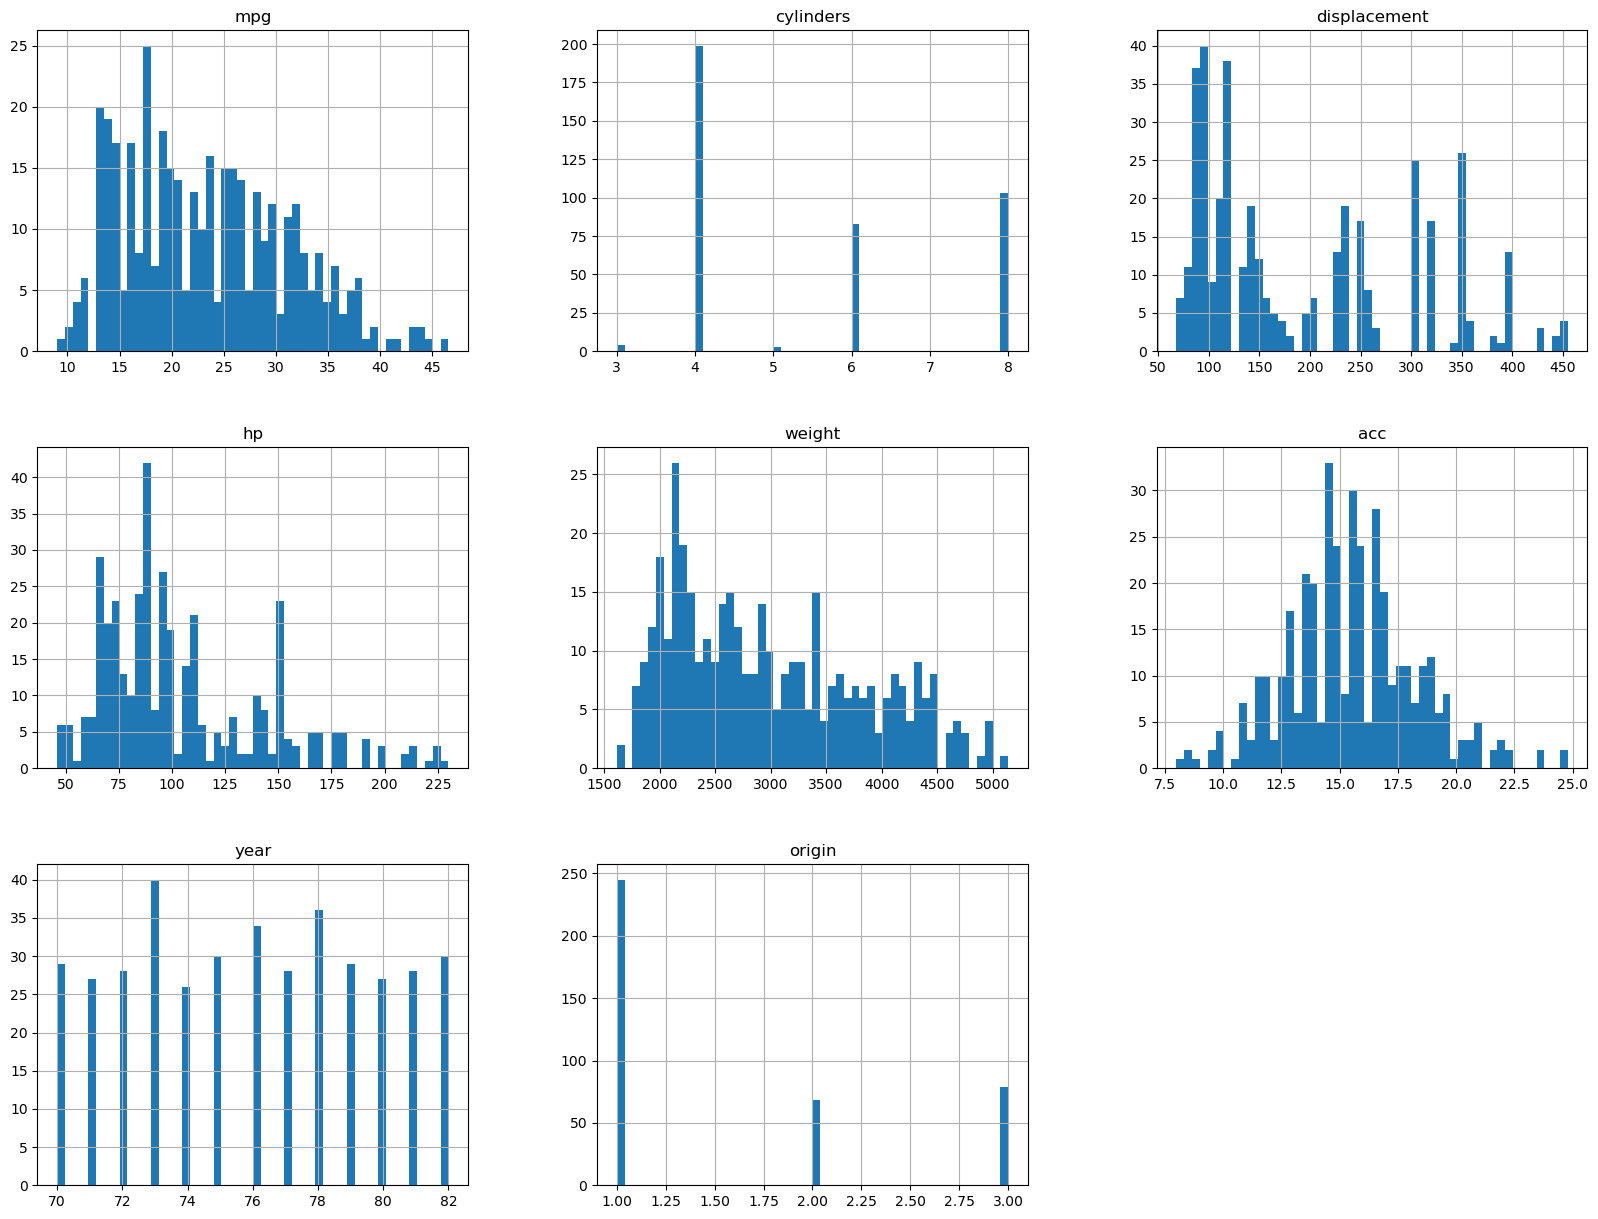

In [6]:
# Plot a histogram of each numerical feature
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
# How much does each feature correlate with the mpg?
corr_matrix = data.corr()
corr_matrix["mpg"].sort_values(ascending=False)

mpg             1.000000
year            0.580541
origin          0.565209
acc             0.423329
cylinders      -0.777618
hp             -0.778427
displacement   -0.805127
weight         -0.832244
Name: mpg, dtype: float64

In [8]:
# Split the dataset in training set (80%) and test set (20%). Use a fixed random seed (42).
# Stratified sampling on the "origin" feature is used here, but a better result can be achieved without.
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, stratify=data['origin'], random_state=42)

In [9]:
# Remove the labels from the training set.
predictors = train_set.drop(columns="mpg")
# Keep the labels in a separate set.
labels = train_set["mpg"].copy()

In [10]:
# Perform the remaining data preparation tasks using a ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn. preprocessing import StandardScaler
from sklearn. preprocessing import MinMaxScaler

# Standardize all the feature attributes except 'origin'
numericalAttributes = ["cylinders", "displacement", "hp", "weight", "acc", "year"]

# Convert the origin attribute to 3 binary attributes using one-hot encoding
categoryAttributes = ["origin"]

preprocessing_pipeline = ColumnTransformer([
    ("scaled", "passthrough", numericalAttributes),  # no transformation of these features because of "passthrough"
    ("onehot", OneHotEncoder(sparse_output=False), categoryAttributes),
])

predictors_prepared = preprocessing_pipeline.fit_transform(predictors)

# Display the prepared dataset (remember that the fit_transform method returns a NumPy array)
predictors_prepared

array([[  4.,  97.,  67., ...,   0.,   0.,   1.],
       [  8., 429., 198., ...,   1.,   0.,   0.],
       [  4., 146.,  67., ...,   0.,   1.,   0.],
       ...,
       [  4., 107.,  86., ...,   0.,   1.,   0.],
       [  4.,  91.,  53., ...,   0.,   0.,   1.],
       [  4., 151.,  90., ...,   1.,   0.,   0.]])

In [11]:
predictors_prepared.shape

(313, 9)

In [12]:
# Train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline

tree_reg = make_pipeline(preprocessing_pipeline, DecisionTreeRegressor(max_depth=8, random_state=42))
tree_reg.fit(predictors, labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaled', 'passthrough',
                                                  ['cylinders', 'displacement',
                                                   'hp', 'weight', 'acc',
                                                   'year']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['origin'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=8, random_state=42))])

In [13]:
# Remove the labels from the test set
X_test = test_set.drop("mpg", axis=1)
# Keep the labels in a separate set
y_test = test_set["mpg"].copy()

In [14]:
# Measure the models RMSE on the test set
from sklearn.metrics import root_mean_squared_error

predictions = tree_reg.predict(X_test)
tree_rmse = root_mean_squared_error(y_test, predictions)
tree_rmse

3.3999789853443008

In [15]:
# Predict mpg for the first row in the test set
tree_reg.predict(X_test.head(1))

# Alternative syntax (see https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html)
# tree_reg.predict(X_test.iloc[:1,:])

array([21.875])

In [16]:
# Display actual mpg for the first row in the test set
y_test.head(1)

# Alternative syntax
# y_test.iloc[:1]

125    20.0
Name: mpg, dtype: float64